# Imports

In [1]:
import os
import ipdb
import argparse
import numpy as np
import pandas as pd
import numpy.random as random
from progressbar import ProgressBar
import matplotlib.pyplot as plt
import gzip
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import json
pd.options.display.max_columns = 9999999

In [3]:
data = []

with gzip.open('movielens_5_injected_G3600.json.gz', 'rt', encoding='utf-16') as f:
    for line in f:
        data.append(json.loads(line))

In [4]:
len(data)

105000

In [5]:
print(data[0])
print(data[1])
print(data[2])
print(data[3])
print(data[4])

{'t': 874724710, 'u': 'bottom_255', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'G', 'history_size': 3600, 'bip': True, 'cost': 0.0}
{'t': 874724727, 'u': 'bottom_286', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'G', 'history_size': 3600, 'bip': True, 'cost': 0.0}
{'t': 874724754, 'u': 'bottom_298', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'G', 'history_size': 3600, 'bip': True, 'cost': 0.0}
{'t': 874724781, 'u': 'bottom_185', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'G', 'history_size': 3600, 'bip': True, 'cost': 0.0}
{'t': 874724843, 'u': 'bottom_173', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'G', 'history_size': 3600, 'bip': True, 'cost': 0.0}


# Flatten the internal `O(1)` features

In [6]:
from utilitiesMe import flatten_dict

In [7]:
data_flattened = []
for row in data:
    data_flattened.append(flatten_dict(row))

In [8]:
data_flattened[0]

{'t': 874724710,
 'u': 'bottom_255',
 'v': 'top_259',
 'is_fraud': 0,
 'history_type': 'G',
 'history_size': 3600,
 'bip': True,
 'cost': 0.0}

# Convert flattened json to dataframe

In [9]:
df = pd.DataFrame.from_dict(data_flattened, orient='columns')

In [10]:
df

,t,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,874724843,bottom_173,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,893286638,bottom_313,top_729,0,G,3600,True,0.0,80.0,69.0,11.0,1.0,2.0,1.0,69.0,11.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,1.0,17.0,69.0,1.0,11.0,1.0,1.0,17.0,69.0,1.0,11.0,1.0,91.0,91.0,91.0,0.0,1.0,1.0,1.0,1.0,91.0,0.0
104996,893286638,bottom_328,top_729,0,G,3600,True,0.0,80.0,68.0,12.0,1.0,2.0,1.0,68.0,12.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,2.0,18.0,12.0,1.0,0.0,1.0,2.0,18.0,12.0,1.0,0.0,1.0,92.0,92.0,92.0,0.0,1.0,1.0,1.0,1.0,92.0,0.0
104997,893286638,bottom_333,top_729,0,G,3600,True,0.0,81.0,69.0,12.0,1.0,2.0,1.0,69.0,12.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,1.0,19.0,69.0,1.0,12.0,1.0,1.0,19.0,69.0,1.0,12.0,1.0,93.0,93.0,93.0,0.0,1.0,1.0,1.0,1.0,93.0,0.0
104998,893286638,bottom_689,top_729,0,G,3600,True,0.0,82.0,70.0,12.0,1.0,2.0,1.0,70.0,12.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,1.0,20.0,70.0,1.0,12.0,1.0,1.0,20.0,70.0,1.0,12.0,1.0,94.0,94.0,94.0,0.0,1.0,1.0,1.0,1.0,94.0,0.0


In [11]:
df.rename(columns={'t': 'timestamp'}, inplace=True)
df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,874724843,bottom_173,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,893286638,bottom_313,top_729,0,G,3600,True,0.0,80.0,69.0,11.0,1.0,2.0,1.0,69.0,11.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,1.0,17.0,69.0,1.0,11.0,1.0,1.0,17.0,69.0,1.0,11.0,1.0,91.0,91.0,91.0,0.0,1.0,1.0,1.0,1.0,91.0,0.0
104996,893286638,bottom_328,top_729,0,G,3600,True,0.0,80.0,68.0,12.0,1.0,2.0,1.0,68.0,12.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,2.0,18.0,12.0,1.0,0.0,1.0,2.0,18.0,12.0,1.0,0.0,1.0,92.0,92.0,92.0,0.0,1.0,1.0,1.0,1.0,92.0,0.0
104997,893286638,bottom_333,top_729,0,G,3600,True,0.0,81.0,69.0,12.0,1.0,2.0,1.0,69.0,12.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,1.0,19.0,69.0,1.0,12.0,1.0,1.0,19.0,69.0,1.0,12.0,1.0,93.0,93.0,93.0,0.0,1.0,1.0,1.0,1.0,93.0,0.0
104998,893286638,bottom_689,top_729,0,G,3600,True,0.0,82.0,70.0,12.0,1.0,2.0,1.0,70.0,12.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,1.0,20.0,70.0,1.0,12.0,1.0,1.0,20.0,70.0,1.0,12.0,1.0,94.0,94.0,94.0,0.0,1.0,1.0,1.0,1.0,94.0,0.0


In [12]:
df.describe()

,timestamp,is_fraud,history_size,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,1.050000e+05,105000.000000,105000.0,1.050000e+05,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.0,104983.0,104983.0,104983.0,104983.0,104983.000000,104983.0
mean,8.835258e+08,0.047619,3600.0,7.440476e-07,110.505710,99.599792,8.454569,1.000038,1.810150,1.000038,99.599792,8.454569,1.000038,1.810150,1.000038,8.121210,5.634331,0.144481,2.343256,77.802835,2.853576,5.634331,0.144481,2.343256,77.802835,2.853576,1.109170,60.257270,87.261299,1.334949,7.230990,0.638942,1.109170,60.257270,87.261299,1.334949,7.230990,0.638942,125.126935,125.126935,125.126935,0.0,1.0,1.0,1.0,1.0,125.126935,0.0
std,5.345223e+06,0.212960,0.0,1.078207e-04,104.801973,85.810009,19.565543,0.006173,1.216552,0.006173,85.810009,19.565543,0.006173,1.216552,0.006173,8.788507,6.698244,0.397748,5.975545,71.931977,6.450825,6.698244,0.397748,5.975545,71.931977,6.450825,0.427697,69.333826,81.336325,2.077607,21.246968,1.584106,0.427697,69.333826,81.336325,2.077607,21.246968,1.584106,141.154172,141.154172,141.154172,0.0,0.0,0.0,0.0,0.0,141.154172,0.0
min,8.747247e+08,0.000000,3600.0,0.000000e+00,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.0,1.0,1.0,1.0,1.0,1.000000,0.0
25%,8.794484e+08,0.000000,3600.0,0.000000e+00,33.000000,32.000000,0.000000,1.000000,1.000000,1.000000,32.000000,0.000000,1.000000,1.000000,1.000000,3.000000,2.000000,0.000000,1.000000,26.000000,1.000000,2.000000,0.000000,1.000000,26.000000,1.000000,1.000000,13.000000,25.000000,1.000000,0.000000,0.000000,1.000000,13.000000,25.000000,1.000000,0.000000,0.000000,33.000000,33.000000,33.000000,0.0,1.0,1.0,1.0,1.0,33.000000,0.0
50%,8.828265e+08,0.000000,3600.0,0.000000e+00,78.000000,76.000000,1.000000,1.000000,2.000000,1.000000,76.000000,1.000000,1.000000,2.000000,1.000000,6.000000,4.000000,0.000000,1.000000,58.000000,1.000000,4.000000,0.000000,1.000000,58.000000,1.000000,1.000000,37.000000,64.000000,1.000000,0.000000,0.000000,1.000000,37.000000,64.000000,1.000000,0.000000,0.000000,80.000000,80.000000,80.000000,0.0,1.0,1.0,1.0,1.0,80.000000,0.0
75%,8.882664e+08,0.000000,3600.0,0.000000e+00,153.000000,144.000000,6.000000,1.000000,2.000000,1.000000,144.000000,6.000000,1.000000,2.000000,1.000000,10.000000,7.000000,0.000000,1.000000,111.000000,1.000000,7.000000,0.000000,1.000000,111.000000,1.000000,1.000000,85.000000,125.000000,1.000000,4.000000,1.000000,1.000000,85.0000

# Remove NaNs

In [13]:
df.head(10)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,874724843,bottom_173,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,874724882,bottom_108,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,874724882,bottom_772,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,874724905,bottom_288,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,874724937,bottom_928,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,874724988,bottom_117,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Create a new DataFrame to preserve rows with NaN
nan_df = pd.DataFrame(columns=df.columns)

# Remove rows with NaN from 'df' and append them to 'nan_df'
nan_rows = df[df.isnull().any(axis=1)]
df = df.dropna()
nan_df = nan_df.append(nan_rows)

# Display the updated 'df' and 'nan_df'
print("Updated DataFrame without NaN:")
df

Updated DataFrame without NaN:


,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
17,874728338,bottom_284,top_851,0,G,3600,True,0.0,16.0,16.0,0.0,1.0,1.0,1.0,16.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,14.0,2.0,0.0,1.0,2.0,14.0,2.0,1.0,2.0,16.0,1.0,0.0,1.0,1.0,2.0,16.0,1.0,0.0,1.0,16.0,16.0,16.0,0.0,1.0,1.0,1.0,1.0,16.0,0.0
18,874728338,bottom_696,top_851,0,G,3600,True,0.0,17.0,17.0,0.0,1.0,1.0,1.0,17.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,3.0,14.0,3.0,0.0,0.0,3.0,14.0,3.0,1.0,3.0,17.0,1.0,0.0,1.0,1.0,3.0,17.0,1.0,0.0,1.0,17.0,17.0,17.0,0.0,1.0,1.0,1.0,1.0,17.0,0.0
19,874728370,bottom_295,top_851,0,G,3600,True,0.0,17.0,17.0,0.0,1.0,1.0,1.0,17.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,4.0,13.0,4.0,0.0,0.0,4.0,13.0,4.0,1.0,4.0,17.0,1.0,0.0,1.0,1.0,4.0,17.0,1.0,0.0,1.0,17.0,17.0,17.0,0.0,1.0,1.0,1.0,1.0,17.0,0.0
20,874728396,bottom_473,top_851,0,G,3600,True,0.0,17.0,17.0,0.0,1.0,1.0,1.0,17.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,5.0,12.0,5.0,0.0,0.0,5.0,12.0,5.0,1.0,5.0,17.0,1.0,0.0,1.0,1.0,5.0,17.0,1.0,0.0,1.0,17.0,17.0,17.0,0.0,1.0,1.0,1.0,1.0,17.0,0.0
21,874728396,bottom_544,top_851,0,G,3600,True,0.0,18.0,18.0,0.0,1.0,1.0,1.0,18.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,6.0,12.0,6.0,0.0,0.0,6.0,12.0,6.0,1.0,6.0,18.0,1.0,0.0,1.0,1.0,6.0,18.0,1.0,0.0,1.0,18.0,18.0,18.0,0.0,1.0,1.0,1.0,1.0,18.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,893286638,bottom_313,top_729,0,G,3600,True,0.0,80.0,69.0,11.0,1.0,2.0,1.0,69.0,11.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,1.0,17.0,69.0,1.0,11.0,1.0,1.0,17.0,69.0,1.0,11.0,1.0,91.0,91.0,91.0,0.0,1.0,1.0,1.0,1.0,91.0,0.0
104996,893286638,bottom_328,top_729,0,G,3600,True,0.0,80.0,68.0,12.0,1.0,2.0,1.0,68.0,12.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,2.0,18.0,12.0,1.0,0.0,1.0,2.0,18.0,12.0,1.0,0.0,1.0,92.0,92.0,92.0,0.0,1.0,1.0,1.0,1.0,92.0,0.0
104997,893286638,bottom_333,top_729,0,G,3600,True,0.0,81.0,69.0,12.0,1.0,2.0,1.0,69.0,12.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,1.0,19.0,69.0,1.0,12.0,1.0,1.0,19.0,69.0,1.0,12.0,1.0,93.0,93.0,93.0,0.0,1.0,1.0,1.0,1.0,93.0,0.0
104998,893286638,bottom_689,top_729,0,G,3600,True,0.0,82.0,70.0,12.0,1.0,2.0,1.0,70.0,12.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,1.0,20.0,70.0,1.0,12.0,1.0,1.0,20.0,70.0,1.0,12.0,1.0,94.0,94.0,94.0,0.0,1.0,1.0,1.0,1.0,94.0,0.0


In [15]:
nan_df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,874724843,bottom_173,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,874724882,bottom_108,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,874724882,bottom_772,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,874724905,bottom_288,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,874724937,bottom_928,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,874724988,bottom_117,top_259,0,G,3600,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df.describe()

,timestamp,is_fraud,history_size,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,1.049830e+05,104983.000000,104983.0,1.049830e+05,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.0,104983.0,104983.0,104983.0,104983.0,104983.000000,104983.0
mean,8.835272e+08,0.047627,3600.0,7.441681e-07,110.505710,99.599792,8.454569,1.000038,1.810150,1.000038,99.599792,8.454569,1.000038,1.810150,1.000038,8.121210,5.634331,0.144481,2.343256,77.802835,2.853576,5.634331,0.144481,2.343256,77.802835,2.853576,1.109170,60.257270,87.261299,1.334949,7.230990,0.638942,1.109170,60.257270,87.261299,1.334949,7.230990,0.638942,125.126935,125.126935,125.126935,0.0,1.0,1.0,1.0,1.0,125.126935,0.0
std,5.344482e+06,0.212976,0.0,1.078294e-04,104.801973,85.810009,19.565543,0.006173,1.216552,0.006173,85.810009,19.565543,0.006173,1.216552,0.006173,8.788507,6.698244,0.397748,5.975545,71.931977,6.450825,6.698244,0.397748,5.975545,71.931977,6.450825,0.427697,69.333826,81.336325,2.077607,21.246968,1.584106,0.427697,69.333826,81.336325,2.077607,21.246968,1.584106,141.154172,141.154172,141.154172,0.0,0.0,0.0,0.0,0.0,141.154172,0.0
min,8.747283e+08,0.000000,3600.0,0.000000e+00,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.0,1.0,1.0,1.0,1.0,1.000000,0.0
25%,8.794486e+08,0.000000,3600.0,0.000000e+00,33.000000,32.000000,0.000000,1.000000,1.000000,1.000000,32.000000,0.000000,1.000000,1.000000,1.000000,3.000000,2.000000,0.000000,1.000000,26.000000,1.000000,2.000000,0.000000,1.000000,26.000000,1.000000,1.000000,13.000000,25.000000,1.000000,0.000000,0.000000,1.000000,13.000000,25.000000,1.000000,0.000000,0.000000,33.000000,33.000000,33.000000,0.0,1.0,1.0,1.0,1.0,33.000000,0.0
50%,8.828266e+08,0.000000,3600.0,0.000000e+00,78.000000,76.000000,1.000000,1.000000,2.000000,1.000000,76.000000,1.000000,1.000000,2.000000,1.000000,6.000000,4.000000,0.000000,1.000000,58.000000,1.000000,4.000000,0.000000,1.000000,58.000000,1.000000,1.000000,37.000000,64.000000,1.000000,0.000000,0.000000,1.000000,37.000000,64.000000,1.000000,0.000000,0.000000,80.000000,80.000000,80.000000,0.0,1.0,1.0,1.0,1.0,80.000000,0.0
75%,8.882664e+08,0.000000,3600.0,0.000000e+00,153.000000,144.000000,6.000000,1.000000,2.000000,1.000000,144.000000,6.000000,1.000000,2.000000,1.000000,10.000000,7.000000,0.000000,1.000000,111.000000,1.000000,7.000000,0.000000,1.000000,111.000000,1.000000,1.000000,85.000000,125.000000,1.000000,4.000000,1.000000,1.000000,85.0000

In [17]:
df_features = df.drop(["timestamp",
                       "u",
                       "v", 
                        "history_type", 
                        "bip", 
                        "cost", # cost of O1 features
                        "history_size"], axis="columns")
df_features

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
17,0,16.0,16.0,0.0,1.0,1.0,1.0,16.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,14.0,2.0,0.0,1.0,2.0,14.0,2.0,1.0,2.0,16.0,1.0,0.0,1.0,1.0,2.0,16.0,1.0,0.0,1.0,16.0,16.0,16.0,0.0,1.0,1.0,1.0,1.0,16.0,0.0
18,0,17.0,17.0,0.0,1.0,1.0,1.0,17.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,3.0,14.0,3.0,0.0,0.0,3.0,14.0,3.0,1.0,3.0,17.0,1.0,0.0,1.0,1.0,3.0,17.0,1.0,0.0,1.0,17.0,17.0,17.0,0.0,1.0,1.0,1.0,1.0,17.0,0.0
19,0,17.0,17.0,0.0,1.0,1.0,1.0,17.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,4.0,13.0,4.0,0.0,0.0,4.0,13.0,4.0,1.0,4.0,17.0,1.0,0.0,1.0,1.0,4.0,17.0,1.0,0.0,1.0,17.0,17.0,17.0,0.0,1.0,1.0,1.0,1.0,17.0,0.0
20,0,17.0,17.0,0.0,1.0,1.0,1.0,17.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,5.0,12.0,5.0,0.0,0.0,5.0,12.0,5.0,1.0,5.0,17.0,1.0,0.0,1.0,1.0,5.0,17.0,1.0,0.0,1.0,17.0,17.0,17.0,0.0,1.0,1.0,1.0,1.0,17.0,0.0
21,0,18.0,18.0,0.0,1.0,1.0,1.0,18.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,6.0,12.0,6.0,0.0,0.0,6.0,12.0,6.0,1.0,6.0,18.0,1.0,0.0,1.0,1.0,6.0,18.0,1.0,0.0,1.0,18.0,18.0,18.0,0.0,1.0,1.0,1.0,1.0,18.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,0,80.0,69.0,11.0,1.0,2.0,1.0,69.0,11.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,1.0,17.0,69.0,1.0,11.0,1.0,1.0,17.0,69.0,1.0,11.0,1.0,91.0,91.0,91.0,0.0,1.0,1.0,1.0,1.0,91.0,0.0
104996,0,80.0,68.0,12.0,1.0,2.0,1.0,68.0,12.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,2.0,18.0,12.0,1.0,0.0,1.0,2.0,18.0,12.0,1.0,0.0,1.0,92.0,92.0,92.0,0.0,1.0,1.0,1.0,1.0,92.0,0.0
104997,0,81.0,69.0,12.0,1.0,2.0,1.0,69.0,12.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,1.0,19.0,69.0,1.0,12.0,1.0,1.0,19.0,69.0,1.0,12.0,1.0,93.0,93.0,93.0,0.0,1.0,1.0,1.0,1.0,93.0,0.0
104998,0,82.0,70.0,12.0,1.0,2.0,1.0,70.0,12.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,1.0,20.0,70.0,1.0,12.0,1.0,1.0,20.0,70.0,1.0,12.0,1.0,94.0,94.0,94.0,0.0,1.0,1.0,1.0,1.0,94.0,0.0


In [18]:
df_features.describe()

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.000000,104983.0,104983.0,104983.0,104983.0,104983.0,104983.000000,104983.0
mean,0.047627,110.505710,99.599792,8.454569,1.000038,1.810150,1.000038,99.599792,8.454569,1.000038,1.810150,1.000038,8.121210,5.634331,0.144481,2.343256,77.802835,2.853576,5.634331,0.144481,2.343256,77.802835,2.853576,1.109170,60.257270,87.261299,1.334949,7.230990,0.638942,1.109170,60.257270,87.261299,1.334949,7.230990,0.638942,125.126935,125.126935,125.126935,0.0,1.0,1.0,1.0,1.0,125.126935,0.0
std,0.212976,104.801973,85.810009,19.565543,0.006173,1.216552,0.006173,85.810009,19.565543,0.006173,1.216552,0.006173,8.788507,6.698244,0.397748,5.975545,71.931977,6.450825,6.698244,0.397748,5.975545,71.931977,6.450825,0.427697,69.333826,81.336325,2.077607,21.246968,1.584106,0.427697,69.333826,81.336325,2.077607,21.246968,1.584106,141.154172,141.154172,141.154172,0.0,0.0,0.0,0.0,0.0,141.154172,0.0
min,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.0,1.0,1.0,1.0,1.0,1.000000,0.0
25%,0.000000,33.000000,32.000000,0.000000,1.000000,1.000000,1.000000,32.000000,0.000000,1.000000,1.000000,1.000000,3.000000,2.000000,0.000000,1.000000,26.000000,1.000000,2.000000,0.000000,1.000000,26.000000,1.000000,1.000000,13.000000,25.000000,1.000000,0.000000,0.000000,1.000000,13.000000,25.000000,1.000000,0.000000,0.000000,33.000000,33.000000,33.000000,0.0,1.0,1.0,1.0,1.0,33.000000,0.0
50%,0.000000,78.000000,76.000000,1.000000,1.000000,2.000000,1.000000,76.000000,1.000000,1.000000,2.000000,1.000000,6.000000,4.000000,0.000000,1.000000,58.000000,1.000000,4.000000,0.000000,1.000000,58.000000,1.000000,1.000000,37.000000,64.000000,1.000000,0.000000,0.000000,1.000000,37.000000,64.000000,1.000000,0.000000,0.000000,80.000000,80.000000,80.000000,0.0,1.0,1.0,1.0,1.0,80.000000,0.0
75%,0.000000,153.000000,144.000000,6.000000,1.000000,2.000000,1.000000,144.000000,6.000000,1.000000,2.000000,1.000000,10.000000,7.000000,0.000000,1.000000,111.000000,1.000000,7.000000,0.000000,1.000000,111.000000,1.000000,1.000000,85.000000,125.000000,1.000000,4.000000,1.000000,1.000000,85.000000,125.000000,1.000000,4.000000,1.000000,160.000000,160.000000,160.000000,0.0,1.0,1.0,1.0,1.0,160.000000,0.0
max,1.000000,600.000000,596.000000,118.000000,2.000000,10.000000,2.000000,596.000000,118.000000,2.000000,10.000000,2.000000,71.000000,54.000000,5.000

In [19]:
df_target = df["is_fraud"]
df_target

17        0
18        0
19        0
20        0
21        0
         ..
104995    0
104996    0
104997    0
104998    0
104999    0
Name: is_fraud, Length: 104983, dtype: int64

# Learning Technique #1: Classical + Underasmpling in training only

## $r$ = 0.7
Before undersampling, take 30% for testing then the 70% take it for training and do undersampling on it

In [20]:
percentage=round(len(df)/100*70) 
train_df=df_features.head(percentage)
test_df=df_features.iloc[percentage:len(df_features),:]

In [21]:
len(train_df) + len(test_df) == len(df)

True

In [22]:
train_df

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
17,0,16.0,16.0,0.0,1.0,1.0,1.0,16.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,14.0,2.0,0.0,1.0,2.0,14.0,2.0,1.0,2.0,16.0,1.0,0.0,1.0,1.0,2.0,16.0,1.0,0.0,1.0,16.0,16.0,16.0,0.0,1.0,1.0,1.0,1.0,16.0,0.0
18,0,17.0,17.0,0.0,1.0,1.0,1.0,17.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,3.0,14.0,3.0,0.0,0.0,3.0,14.0,3.0,1.0,3.0,17.0,1.0,0.0,1.0,1.0,3.0,17.0,1.0,0.0,1.0,17.0,17.0,17.0,0.0,1.0,1.0,1.0,1.0,17.0,0.0
19,0,17.0,17.0,0.0,1.0,1.0,1.0,17.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,4.0,13.0,4.0,0.0,0.0,4.0,13.0,4.0,1.0,4.0,17.0,1.0,0.0,1.0,1.0,4.0,17.0,1.0,0.0,1.0,17.0,17.0,17.0,0.0,1.0,1.0,1.0,1.0,17.0,0.0
20,0,17.0,17.0,0.0,1.0,1.0,1.0,17.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,5.0,12.0,5.0,0.0,0.0,5.0,12.0,5.0,1.0,5.0,17.0,1.0,0.0,1.0,1.0,5.0,17.0,1.0,0.0,1.0,17.0,17.0,17.0,0.0,1.0,1.0,1.0,1.0,17.0,0.0
21,0,18.0,18.0,0.0,1.0,1.0,1.0,18.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,6.0,12.0,6.0,0.0,0.0,6.0,12.0,6.0,1.0,6.0,18.0,1.0,0.0,1.0,1.0,6.0,18.0,1.0,0.0,1.0,18.0,18.0,18.0,0.0,1.0,1.0,1.0,1.0,18.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73500,0,77.0,77.0,0.0,1.0,1.0,1.0,77.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,66.0,10.0,1.0,0.0,1.0,66.0,10.0,1.0,66.0,77.0,1.0,0.0,0.0,1.0,66.0,77.0,1.0,0.0,0.0,77.0,77.0,77.0,0.0,1.0,1.0,1.0,1.0,77.0,0.0
73501,0,78.0,78.0,0.0,1.0,1.0,1.0,78.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,67.0,10.0,1.0,0.0,1.0,67.0,10.0,1.0,67.0,78.0,1.0,0.0,0.0,1.0,67.0,78.0,1.0,0.0,0.0,78.0,78.0,78.0,0.0,1.0,1.0,1.0,1.0,78.0,0.0
73502,0,79.0,79.0,0.0,1.0,1.0,1.0,79.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,68.0,10.0,1.0,0.0,1.0,68.0,10.0,1.0,68.0,79.0,1.0,0.0,0.0,1.0,68.0,79.0,1.0,0.0,0.0,79.0,79.0,79.0,0.0,1.0,1.0,1.0,1.0,79.0,0.0
73503,0,80.0,80.0,0.0,1.0,1.0,1.0,80.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,69.0,10.0,1.0,0.0,1.0,69.0,10.0,1.0,69.0,80.0,1.0,0.0,0.0,1.0,69.0,80.0,1.0,0.0,0.0,80.0,80.0,80.0,0.0,1.0,1.0,1.0,1.0,80.0,0.0


In [23]:
test_df

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
73505,0,82.0,82.0,0.0,1.0,1.0,1.0,82.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,71.0,10.0,1.0,0.0,1.0,71.0,10.0,1.0,71.0,82.0,1.0,0.0,0.0,1.0,71.0,82.0,1.0,0.0,0.0,82.0,82.0,82.0,0.0,1.0,1.0,1.0,1.0,82.0,0.0
73506,0,83.0,83.0,0.0,1.0,1.0,1.0,83.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,72.0,10.0,1.0,0.0,1.0,72.0,10.0,1.0,72.0,83.0,1.0,0.0,0.0,1.0,72.0,83.0,1.0,0.0,0.0,83.0,83.0,83.0,0.0,1.0,1.0,1.0,1.0,83.0,0.0
73507,0,84.0,84.0,0.0,1.0,1.0,1.0,84.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,73.0,10.0,1.0,0.0,1.0,73.0,10.0,1.0,73.0,84.0,1.0,0.0,0.0,1.0,73.0,84.0,1.0,0.0,0.0,84.0,84.0,84.0,0.0,1.0,1.0,1.0,1.0,84.0,0.0
73508,0,85.0,85.0,0.0,1.0,1.0,1.0,85.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,74.0,10.0,1.0,0.0,1.0,74.0,10.0,1.0,74.0,85.0,1.0,0.0,0.0,1.0,74.0,85.0,1.0,0.0,0.0,85.0,85.0,85.0,0.0,1.0,1.0,1.0,1.0,85.0,0.0
73509,1,85.0,85.0,0.0,1.0,1.0,1.0,85.0,0.0,1.0,1.0,1.0,4.0,2.0,0.0,1.0,74.0,1.0,2.0,0.0,1.0,74.0,1.0,1.0,1.0,85.0,2.0,0.0,2.0,1.0,1.0,85.0,2.0,0.0,2.0,85.0,85.0,85.0,0.0,1.0,1.0,1.0,1.0,85.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,0,80.0,69.0,11.0,1.0,2.0,1.0,69.0,11.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,1.0,17.0,69.0,1.0,11.0,1.0,1.0,17.0,69.0,1.0,11.0,1.0,91.0,91.0,91.0,0.0,1.0,1.0,1.0,1.0,91.0,0.0
104996,0,80.0,68.0,12.0,1.0,2.0,1.0,68.0,12.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,2.0,18.0,12.0,1.0,0.0,1.0,2.0,18.0,12.0,1.0,0.0,1.0,92.0,92.0,92.0,0.0,1.0,1.0,1.0,1.0,92.0,0.0
104997,0,81.0,69.0,12.0,1.0,2.0,1.0,69.0,12.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,1.0,19.0,69.0,1.0,12.0,1.0,1.0,19.0,69.0,1.0,12.0,1.0,93.0,93.0,93.0,0.0,1.0,1.0,1.0,1.0,93.0,0.0
104998,0,82.0,70.0,12.0,1.0,2.0,1.0,70.0,12.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,1.0,20.0,70.0,1.0,12.0,1.0,1.0,20.0,70.0,1.0,12.0,1.0,94.0,94.0,94.0,0.0,1.0,1.0,1.0,1.0,94.0,0.0


### Undersampling and training on `X_train, y_train`

In [24]:
train_df["is_fraud"].value_counts()

0    69998
1     3490
Name: is_fraud, dtype: int64

In [25]:
# Separating the data for analysis (they will be Series)
nonanomalous = train_df[train_df.is_fraud == 0]
anomalous = train_df[train_df.is_fraud == 1]

In [26]:
print(len(nonanomalous))
print(len(anomalous))

69998
3490


In [27]:
print(nonanomalous.shape)
print(anomalous.shape)

(69998, 45)
(3490, 45)


In [28]:
train_df.groupby("is_fraud").mean()

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,106.541473,96.956699,7.671091,1.000029,1.760707,1.000029,96.956699,7.671091,1.000029,1.760707,1.000029,7.417455,5.074174,0.125089,2.41454,76.495671,2.949927,5.074174,0.125089,2.41454,76.495671,2.949927,1.102932,62.535458,85.436041,1.069002,6.382511,0.500629,1.102932,62.535458,85.436041,1.069002,6.382511,0.500629,118.833895,118.833895,118.833895,0.0,1.0,1.0,1.0,1.0,118.833895,0.0
1,95.396848,86.789112,6.780516,1.000000,1.727221,1.000000,86.789112,6.780516,1.000000,1.727221,1.000000,8.112894,5.840115,0.136390,1.00000,66.814040,1.245845,5.840115,0.136390,1.00000,66.814040,1.245845,1.054441,1.149857,79.827221,5.768481,7.686533,2.255301,1.054441,1.149857,79.827221,5.768481,7.686533,2.255301,106.583095,106.583095,106.583095,0.0,1.0,1.0,1.0,1.0,106.583095,0.0


In [29]:
# Sampling
nonanomalous_sample = nonanomalous.sample(n = len(anomalous), random_state=12)

In [30]:
# Concatenating
new_dataset = pd.concat([nonanomalous_sample, anomalous], axis=0)

In [31]:
new_dataset

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
20246,0,24.0,24.0,0.0,1.0,1.0,1.0,24.0,0.0,1.0,1.0,1.0,4.0,3.0,0.0,1.0,21.0,1.0,3.0,0.0,1.0,21.0,1.0,1.0,21.0,24.0,1.0,0.0,0.0,1.0,21.0,24.0,1.0,0.0,0.0,24.0,24.0,24.0,0.0,1.0,1.0,1.0,1.0,24.0,0.0
34748,0,118.0,115.0,3.0,1.0,2.0,1.0,115.0,3.0,1.0,2.0,1.0,5.0,3.0,0.0,1.0,75.0,1.0,3.0,0.0,1.0,75.0,1.0,1.0,43.0,115.0,1.0,3.0,1.0,1.0,43.0,115.0,1.0,3.0,1.0,121.0,121.0,121.0,0.0,1.0,1.0,1.0,1.0,121.0,0.0
35316,0,32.0,32.0,0.0,1.0,1.0,1.0,32.0,0.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,30.0,1.0,2.0,0.0,1.0,30.0,1.0,1.0,30.0,32.0,1.0,0.0,0.0,1.0,30.0,32.0,1.0,0.0,0.0,32.0,32.0,32.0,0.0,1.0,1.0,1.0,1.0,32.0,0.0
38965,0,40.0,40.0,0.0,1.0,1.0,1.0,40.0,0.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,31.0,4.0,1.0,0.0,1.0,31.0,4.0,1.0,31.0,40.0,1.0,0.0,0.0,1.0,31.0,40.0,1.0,0.0,0.0,40.0,40.0,40.0,0.0,1.0,1.0,1.0,1.0,40.0,0.0
54548,0,53.0,44.0,9.0,1.0,2.0,1.0,44.0,9.0,1.0,2.0,1.0,6.0,4.0,0.0,1.0,40.0,1.0,4.0,0.0,1.0,40.0,1.0,2.0,18.0,9.0,1.0,0.0,1.0,2.0,18.0,9.0,1.0,0.0,1.0,62.0,62.0,62.0,0.0,1.0,1.0,1.0,1.0,62.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73366,1,112.0,110.0,2.0,1.0,2.0,1.0,110.0,2.0,1.0,2.0,1.0,11.0,9.0,0.0,1.0,90.0,1.0,9.0,0.0,1.0,90.0,1.0,1.0,1.0,110.0,9.0,2.0,2.0,1.0,1.0,110.0,9.0,2.0,2.0,114.0,114.0,114.0,0.0,1.0,1.0,1.0,1.0,114.0,0.0
73386,1,126.0,123.0,3.0,1.0,2.0,1.0,123.0,3.0,1.0,2.0,1.0,12.0,10.0,0.0,1.0,109.0,1.0,10.0,0.0,1.0,109.0,1.0,1.0,1.0,123.0,10.0,3.0,2.0,1.0,1.0,123.0,10.0,3.0,2.0,129.0,129.0,129.0,0.0,1.0,1.0,1.0,1.0,129.0,0.0
73396,1,136.0,133.0,3.0,1.0,2.0,1.0,133.0,3.0,1.0,2.0,1.0,13.0,11.0,0.0,1.0,118.0,1.0,11.0,0.0,1.0,118.0,1.0,1.0,1.0,133.0,11.0,3.0,2.0,1.0,1.0,133.0,11.0,3.0,2.0,139.0,139.0,139.0,0.0,1.0,1.0,1.0,1.0,139.0,0.0
73408,1,148.0,145.0,3.0,1.0,2.0,1.0,145.0,3.0,1.0,2.0,1.0,14.0,12.0,0.0,1.0,129.0,1.0,12.0,0.0,1.0,129.0,1.0,1.0,1.0,145.0,12.0,3.0,2.0,1.0,1.0,145.0,12.0,3.0,2.0,151.0,151.0,151.0,0.0,1.0,1.0,1.0,1.0,151.0,0.0


Author: Now the rows of the `nonanomalous` are random

In [32]:
# Now we will check deeper the values on the new dataset and compare them
new_dataset["is_fraud"].value_counts()

0    3490
1    3490
Name: is_fraud, dtype: int64

In [33]:
new_dataset.groupby("is_fraud").mean()

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,105.526648,95.953295,7.612321,1.0,1.759312,1.0,95.953295,7.612321,1.0,1.759312,1.0,7.408023,5.042980,0.124928,2.380229,75.377937,2.940974,5.042980,0.124928,2.380229,75.377937,2.940974,1.100860,61.542407,84.181089,1.054441,6.439828,0.488252,1.100860,61.542407,84.181089,1.054441,6.439828,0.488252,117.910029,117.910029,117.910029,0.0,1.0,1.0,1.0,1.0,117.910029,0.0
1,95.396848,86.789112,6.780516,1.0,1.727221,1.0,86.789112,6.780516,1.0,1.727221,1.0,8.112894,5.840115,0.136390,1.000000,66.814040,1.245845,5.840115,0.136390,1.000000,66.814040,1.245845,1.054441,1.149857,79.827221,5.768481,7.686533,2.255301,1.054441,1.149857,79.827221,5.768481,7.686533,2.255301,106.583095,106.583095,106.583095,0.0,1.0,1.0,1.0,1.0,106.583095,0.0


In [34]:
new_dataset

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
20246,0,24.0,24.0,0.0,1.0,1.0,1.0,24.0,0.0,1.0,1.0,1.0,4.0,3.0,0.0,1.0,21.0,1.0,3.0,0.0,1.0,21.0,1.0,1.0,21.0,24.0,1.0,0.0,0.0,1.0,21.0,24.0,1.0,0.0,0.0,24.0,24.0,24.0,0.0,1.0,1.0,1.0,1.0,24.0,0.0
34748,0,118.0,115.0,3.0,1.0,2.0,1.0,115.0,3.0,1.0,2.0,1.0,5.0,3.0,0.0,1.0,75.0,1.0,3.0,0.0,1.0,75.0,1.0,1.0,43.0,115.0,1.0,3.0,1.0,1.0,43.0,115.0,1.0,3.0,1.0,121.0,121.0,121.0,0.0,1.0,1.0,1.0,1.0,121.0,0.0
35316,0,32.0,32.0,0.0,1.0,1.0,1.0,32.0,0.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,30.0,1.0,2.0,0.0,1.0,30.0,1.0,1.0,30.0,32.0,1.0,0.0,0.0,1.0,30.0,32.0,1.0,0.0,0.0,32.0,32.0,32.0,0.0,1.0,1.0,1.0,1.0,32.0,0.0
38965,0,40.0,40.0,0.0,1.0,1.0,1.0,40.0,0.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,31.0,4.0,1.0,0.0,1.0,31.0,4.0,1.0,31.0,40.0,1.0,0.0,0.0,1.0,31.0,40.0,1.0,0.0,0.0,40.0,40.0,40.0,0.0,1.0,1.0,1.0,1.0,40.0,0.0
54548,0,53.0,44.0,9.0,1.0,2.0,1.0,44.0,9.0,1.0,2.0,1.0,6.0,4.0,0.0,1.0,40.0,1.0,4.0,0.0,1.0,40.0,1.0,2.0,18.0,9.0,1.0,0.0,1.0,2.0,18.0,9.0,1.0,0.0,1.0,62.0,62.0,62.0,0.0,1.0,1.0,1.0,1.0,62.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73366,1,112.0,110.0,2.0,1.0,2.0,1.0,110.0,2.0,1.0,2.0,1.0,11.0,9.0,0.0,1.0,90.0,1.0,9.0,0.0,1.0,90.0,1.0,1.0,1.0,110.0,9.0,2.0,2.0,1.0,1.0,110.0,9.0,2.0,2.0,114.0,114.0,114.0,0.0,1.0,1.0,1.0,1.0,114.0,0.0
73386,1,126.0,123.0,3.0,1.0,2.0,1.0,123.0,3.0,1.0,2.0,1.0,12.0,10.0,0.0,1.0,109.0,1.0,10.0,0.0,1.0,109.0,1.0,1.0,1.0,123.0,10.0,3.0,2.0,1.0,1.0,123.0,10.0,3.0,2.0,129.0,129.0,129.0,0.0,1.0,1.0,1.0,1.0,129.0,0.0
73396,1,136.0,133.0,3.0,1.0,2.0,1.0,133.0,3.0,1.0,2.0,1.0,13.0,11.0,0.0,1.0,118.0,1.0,11.0,0.0,1.0,118.0,1.0,1.0,1.0,133.0,11.0,3.0,2.0,1.0,1.0,133.0,11.0,3.0,2.0,139.0,139.0,139.0,0.0,1.0,1.0,1.0,1.0,139.0,0.0
73408,1,148.0,145.0,3.0,1.0,2.0,1.0,145.0,3.0,1.0,2.0,1.0,14.0,12.0,0.0,1.0,129.0,1.0,12.0,0.0,1.0,129.0,1.0,1.0,1.0,145.0,12.0,3.0,2.0,1.0,1.0,145.0,12.0,3.0,2.0,151.0,151.0,151.0,0.0,1.0,1.0,1.0,1.0,151.0,0.0


In [35]:
new_dataset = new_dataset.sample(frac=1, random_state=42)  # frac=1 means we sample 100% of the data
new_dataset

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
12595,1,14.0,14.0,0.0,1.0,1.0,1.0,14.0,0.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,12.0,1.0,2.0,0.0,1.0,12.0,1.0,1.0,1.0,14.0,2.0,0.0,1.0,1.0,1.0,14.0,2.0,0.0,1.0,14.0,14.0,14.0,0.0,1.0,1.0,1.0,1.0,14.0,0.0
60551,0,153.0,153.0,0.0,1.0,1.0,1.0,153.0,0.0,1.0,1.0,1.0,10.0,9.0,0.0,1.0,144.0,1.0,9.0,0.0,1.0,144.0,1.0,1.0,144.0,153.0,1.0,0.0,0.0,1.0,144.0,153.0,1.0,0.0,0.0,153.0,153.0,153.0,0.0,1.0,1.0,1.0,1.0,153.0,0.0
16994,1,64.0,64.0,0.0,1.0,1.0,1.0,64.0,0.0,1.0,1.0,1.0,4.0,3.0,0.0,1.0,61.0,1.0,3.0,0.0,1.0,61.0,1.0,1.0,1.0,64.0,3.0,0.0,1.0,1.0,1.0,64.0,3.0,0.0,1.0,64.0,64.0,64.0,0.0,1.0,1.0,1.0,1.0,64.0,0.0
16501,0,17.0,17.0,0.0,1.0,1.0,1.0,17.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,13.0,3.0,1.0,0.0,1.0,13.0,3.0,1.0,13.0,17.0,1.0,0.0,0.0,1.0,13.0,17.0,1.0,0.0,0.0,17.0,17.0,17.0,0.0,1.0,1.0,1.0,1.0,17.0,0.0
801,0,201.0,196.0,5.0,1.0,2.0,1.0,196.0,5.0,1.0,2.0,1.0,13.0,8.0,1.0,1.0,154.0,1.0,8.0,1.0,1.0,154.0,1.0,1.0,154.0,196.0,1.0,5.0,0.0,1.0,154.0,196.0,1.0,5.0,0.0,206.0,206.0,206.0,0.0,1.0,1.0,1.0,1.0,206.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5833,1,13.0,13.0,0.0,1.0,1.0,1.0,13.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,9.0,3.0,1.0,0.0,1.0,9.0,3.0,1.0,1.0,13.0,1.0,0.0,2.0,1.0,1.0,13.0,1.0,0.0,2.0,13.0,13.0,13.0,0.0,1.0,1.0,1.0,1.0,13.0,0.0
35503,1,83.0,82.0,1.0,1.0,2.0,1.0,82.0,1.0,1.0,2.0,1.0,11.0,9.0,0.0,1.0,42.0,1.0,9.0,0.0,1.0,42.0,1.0,1.0,1.0,82.0,9.0,1.0,2.0,1.0,1.0,82.0,9.0,1.0,2.0,84.0,84.0,84.0,0.0,1.0,1.0,1.0,1.0,84.0,0.0
36332,1,193.0,176.0,17.0,1.0,2.0,1.0,176.0,17.0,1.0,2.0,1.0,11.0,9.0,0.0,1.0,144.0,1.0,9.0,0.0,1.0,144.0,1.0,1.0,1.0,176.0,9.0,17.0,2.0,1.0,1.0,176.0,9.0,17.0,2.0,210.0,210.0,210.0,0.0,1.0,1.0,1.0,1.0,210.0,0.0
39587,1,33.0,33.0,0.0,1.0,1.0,1.0,33.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,29.0,3.0,1.0,0.0,1.0,29.0,3.0,1.0,1.0,33.0,1.0,0.0,2.0,1.0,1.0,33.0,1.0,0.0,2.0,33.0,33.0,33.0,0.0,1.0,1.0,1.0,1.0,33.0,0.0


In [36]:
# Specify the features (X) and the target variable (y)
X_train = new_dataset.drop('is_fraud', axis=1)
y_train = new_dataset['is_fraud']

rf_classifier = RandomForestClassifier(random_state=42)

rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Testing on `X_test, y_test`

In [37]:
test_df["is_fraud"].value_counts()

0    29985
1     1510
Name: is_fraud, dtype: int64

In [38]:
test_df.groupby("is_fraud").mean()

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,120.875705,106.873470,10.309688,1.000067,1.926430,1.000067,106.873470,10.309688,1.000067,1.926430,1.000067,9.609805,6.782258,0.187460,2.400834,81.998366,2.896782,6.782258,0.187460,2.400834,81.998366,2.896782,1.131099,64.794364,91.984426,1.097749,8.841254,0.662965,1.131099,64.794364,91.984426,1.097749,8.841254,0.662965,140.930165,140.930165,140.930165,0.0,1.0,1.0,1.0,1.0,140.930165,0.0
1,123.270199,107.294702,11.804636,1.000000,1.984768,1.000000,107.294702,11.804636,1.000000,1.984768,1.000000,11.203974,8.330464,0.208609,1.000000,80.482781,1.245033,8.330464,0.208609,1.000000,80.482781,1.245033,1.089404,1.165563,95.265563,8.126490,13.534437,2.837748,1.089404,1.165563,95.265563,8.126490,13.534437,2.837748,145.894040,145.894040,145.894040,0.0,1.0,1.0,1.0,1.0,145.894040,0.0


In [39]:
# Specify the features (X) and the target variable (y)
X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

In [40]:
test_df["is_fraud"].value_counts()

0    29985
1     1510
Name: is_fraud, dtype: int64

In [41]:
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])

print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9923


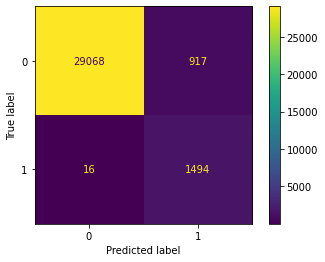

In [42]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
disp.plot()

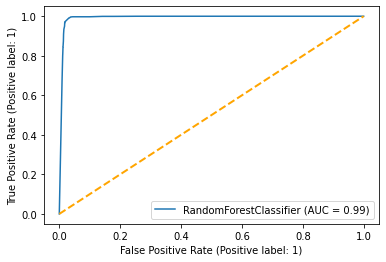

In [43]:
from sklearn.metrics import RocCurveDisplay
rfc_disp = RocCurveDisplay.from_estimator(rf_classifier, X_test, y_test)
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')

# Learning Technique #2: Sliding window with undersampling in training only

In [44]:
df.reset_index(drop=True, inplace=True)

In [45]:
# Specify the features (X) and the target variable (y)
X = df.drop(["timestamp", 
             "u", 
             "v", 
             "history_type", 
             "bip", 
             "cost", # cost of O1 features
             "history_size",
             "is_fraud",], axis="columns")
y = df["is_fraud"]

In [46]:
X

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,16.0,16.0,0.0,1.0,1.0,1.0,16.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,14.0,2.0,0.0,1.0,2.0,14.0,2.0,1.0,2.0,16.0,1.0,0.0,1.0,1.0,2.0,16.0,1.0,0.0,1.0,16.0,16.0,16.0,0.0,1.0,1.0,1.0,1.0,16.0,0.0
1,17.0,17.0,0.0,1.0,1.0,1.0,17.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,3.0,14.0,3.0,0.0,0.0,3.0,14.0,3.0,1.0,3.0,17.0,1.0,0.0,1.0,1.0,3.0,17.0,1.0,0.0,1.0,17.0,17.0,17.0,0.0,1.0,1.0,1.0,1.0,17.0,0.0
2,17.0,17.0,0.0,1.0,1.0,1.0,17.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,4.0,13.0,4.0,0.0,0.0,4.0,13.0,4.0,1.0,4.0,17.0,1.0,0.0,1.0,1.0,4.0,17.0,1.0,0.0,1.0,17.0,17.0,17.0,0.0,1.0,1.0,1.0,1.0,17.0,0.0
3,17.0,17.0,0.0,1.0,1.0,1.0,17.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,5.0,12.0,5.0,0.0,0.0,5.0,12.0,5.0,1.0,5.0,17.0,1.0,0.0,1.0,1.0,5.0,17.0,1.0,0.0,1.0,17.0,17.0,17.0,0.0,1.0,1.0,1.0,1.0,17.0,0.0
4,18.0,18.0,0.0,1.0,1.0,1.0,18.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,6.0,12.0,6.0,0.0,0.0,6.0,12.0,6.0,1.0,6.0,18.0,1.0,0.0,1.0,1.0,6.0,18.0,1.0,0.0,1.0,18.0,18.0,18.0,0.0,1.0,1.0,1.0,1.0,18.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104978,80.0,69.0,11.0,1.0,2.0,1.0,69.0,11.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,1.0,17.0,69.0,1.0,11.0,1.0,1.0,17.0,69.0,1.0,11.0,1.0,91.0,91.0,91.0,0.0,1.0,1.0,1.0,1.0,91.0,0.0
104979,80.0,68.0,12.0,1.0,2.0,1.0,68.0,12.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,2.0,18.0,12.0,1.0,0.0,1.0,2.0,18.0,12.0,1.0,0.0,1.0,92.0,92.0,92.0,0.0,1.0,1.0,1.0,1.0,92.0,0.0
104980,81.0,69.0,12.0,1.0,2.0,1.0,69.0,12.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,1.0,19.0,69.0,1.0,12.0,1.0,1.0,19.0,69.0,1.0,12.0,1.0,93.0,93.0,93.0,0.0,1.0,1.0,1.0,1.0,93.0,0.0
104981,82.0,70.0,12.0,1.0,2.0,1.0,70.0,12.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,1.0,20.0,70.0,1.0,12.0,1.0,1.0,20.0,70.0,1.0,12.0,1.0,94.0,94.0,94.0,0.0,1.0,1.0,1.0,1.0,94.0,0.0


In [47]:
y

0         0
1         0
2         0
3         0
4         0
         ..
104978    0
104979    0
104980    0
104981    0
104982    0
Name: is_fraud, Length: 104983, dtype: int64

In [48]:
len(df) / 2

52491.5

In [49]:
len(df)

104983

In [50]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

Delta: 1049 



In [51]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

roc_auc_results = []
c = 1

# Start the sliding window with overlap
for i in range(0, int(len(df) / 2), delta):
    b_i = i
    e_i = i + int(len(df) / 2)

    X_subset = X.iloc[b_i:e_i]
    y_subset = y.iloc[b_i:e_i]
    print(X_subset.index)

    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, shuffle=False)

    # Undersample the majority class (0) within each window
    X_train_sampled = pd.concat([X_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), X_train[y_train == 1]])
    y_train_sampled = pd.concat([y_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), y_train[y_train == 1]])

    # Compute counts of y = 1 and y = 0 for y_train
    y_train_1_count = sum(y_train_sampled == 1)
    y_train_0_count = sum(y_train_sampled == 0)
    
    # Compute counts of y = 1 and y = 0 for y_test
    y_test_1_count = sum(y_test == 1)
    y_test_0_count = sum(y_test == 0)
    
    print(f"Iteration {c}:")
    print(f"Counts of y = 1 and y = 0 in y_train: {y_train_1_count}, {y_train_0_count}")
    print(f"Counts of y = 1 and y = 0 in y_test: {y_test_1_count}, {y_test_0_count}")
    c += 1
    
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_sampled, y_train_sampled)
    y_pred = clf.predict(X_test)

    try:
        roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    except ValueError as e:
        continue

    roc_auc_results.append(roc_auc)
    print(b_i)
    print(f"Iteration difference {e_i - b_i}: ROC-AUC={roc_auc:.4f}")
    print("------------------------------------------------------------------------------------------------")

average_roc_auc = sum(roc_auc_results) / len(roc_auc_results)

print(f"Average ROC-AUC: {average_roc_auc:.4f}")


Delta: 1049 

RangeIndex(start=0, stop=52491, step=1)
Iteration 1:
Counts of y = 1 and y = 0 in y_train: 2044, 2044
Counts of y = 1 and y = 0 in y_test: 486, 10013
0
Iteration difference 52491: ROC-AUC=0.9925
------------------------------------------------------------------------------------------------
RangeIndex(start=1049, stop=53540, step=1)
Iteration 2:
Counts of y = 1 and y = 0 in y_train: 2046, 2046
Counts of y = 1 and y = 0 in y_test: 479, 10020
1049
Iteration difference 52491: ROC-AUC=0.9917
------------------------------------------------------------------------------------------------
RangeIndex(start=2098, stop=54589, step=1)
Iteration 3:
Counts of y = 1 and y = 0 in y_train: 2059, 2059
Counts of y = 1 and y = 0 in y_test: 479, 10020
2098
Iteration difference 52491: ROC-AUC=0.9937
------------------------------------------------------------------------------------------------
RangeIndex(start=3147, stop=55638, step=1)
Iteration 4:
Counts of y = 1 and y = 0 in y_train: 2056

28323
Iteration difference 52491: ROC-AUC=0.9924
------------------------------------------------------------------------------------------------
RangeIndex(start=29372, stop=81863, step=1)
Iteration 29:
Counts of y = 1 and y = 0 in y_train: 1965, 1965
Counts of y = 1 and y = 0 in y_test: 503, 9996
29372
Iteration difference 52491: ROC-AUC=0.9925
------------------------------------------------------------------------------------------------
RangeIndex(start=30421, stop=82912, step=1)
Iteration 30:
Counts of y = 1 and y = 0 in y_train: 1985, 1985
Counts of y = 1 and y = 0 in y_test: 490, 10009
30421
Iteration difference 52491: ROC-AUC=0.9923
------------------------------------------------------------------------------------------------
RangeIndex(start=31470, stop=83961, step=1)
Iteration 31:
Counts of y = 1 and y = 0 in y_train: 1990, 1990
Counts of y = 1 and y = 0 in y_test: 497, 10002
31470
Iteration difference 52491: ROC-AUC=0.9926
-------------------------------------------------

In [52]:
df.tail(2)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
104981,893286638,bottom_689,top_729,0,G,3600,True,0.0,82.0,70.0,12.0,1.0,2.0,1.0,70.0,12.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,1.0,20.0,70.0,1.0,12.0,1.0,1.0,20.0,70.0,1.0,12.0,1.0,94.0,94.0,94.0,0.0,1.0,1.0,1.0,1.0,94.0,0.0
104982,893286638,bottom_748,top_729,0,G,3600,True,0.0,82.0,69.0,13.0,1.0,2.0,1.0,69.0,13.0,1.0,2.0,1.0,7.0,5.0,0.0,1.0,69.0,1.0,5.0,0.0,1.0,69.0,1.0,2.0,21.0,13.0,1.0,0.0,1.0,2.0,21.0,13.0,1.0,0.0,1.0,95.0,95.0,95.0,0.0,1.0,1.0,1.0,1.0,95.0,0.0


In [53]:
# Create a DataFrame
df2 = pd.DataFrame({"Values": roc_auc_results})

# Export DataFrame to Excel
df2.to_excel("MovieLens-5Perc-G3600-AUCInSlidingWindow.xlsx", index=False)

In [54]:
len(roc_auc_results)

51

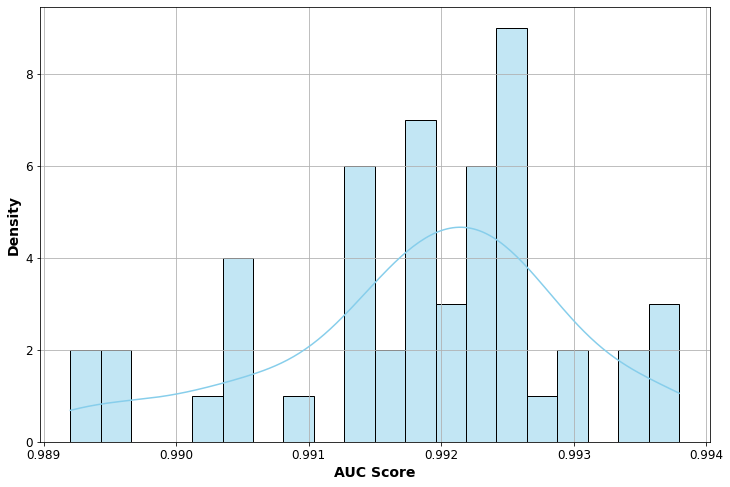

In [55]:
import seaborn as sns

# Plot the distribution with kernel density estimate
plt.figure(figsize=(12, 8))
sns.histplot(df2["Values"], kde=True, bins=20, color='skyblue')
plt.xlabel("AUC Score", fontsize=14,  fontweight='bold')
plt.ylabel("Density", fontsize=14,  fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()